In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from quad_utils import *
from other_utils import *


### MC Integration

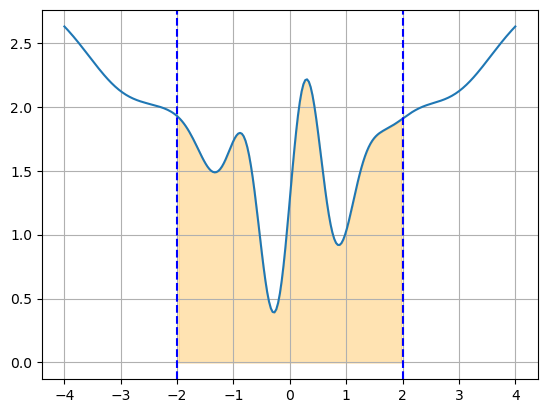

True value: 5.96051236421104

Normal Monte Carlo:
Value: 5.981796, Absolute Error: 0.021283, StDev:0.056013

Monte Carlo with Antithetic Variables:
Value: 5.935085, Absolute Error: 0.025427, StDev:0.025068


In [2]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y)
plt.axvline(lower, color='b', linestyle='--',)
plt.axvline(upper, color='b', linestyle='--',)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.grid()
plt.show()

n = 1000
true_value = 5.96051236421104

#Normal MC
x = np.random.uniform(0,1,n)
x1 = lower + x*interval
mc = jnp.mean(f(x1))*interval
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)*interval

n = 1000
#MC with Antithetic Variables
x = 1 - x
x2 = lower + x*interval
mc_at = (0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2)))*interval
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)*interval

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

## Univariate No Measure
### Integrating $f(t)$


$$
\boxed{v[k] = \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]}
$$     

$$
\boxed{vv[k] = \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right]}
$$


$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where 

$$
\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)dt,\, \int_a^x k(t, x_2)dt,\, \cdots ,\, \int_a^x k(t, x_n)dt \Big],
$$

$$
K(x'x) = \int_a^x \int_a^{x'} k(t, s)\,ds\,dt 
$$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [3]:
#no mean function
def gp_predict_1(xs, ys, x_eval, kernel, s, L, m0=None, x_m=None,w=None):
    xs = jnp.asarray(xs)
    x_eval = jnp.asarray(x_eval)
    ys = jnp.asarray(ys)
    L = jnp.asarray(L)

    # Ensure 2D arrays
    if xs.ndim == 1:
        xs = xs[:, None]
    if x_eval.ndim == 1:
        x_eval = x_eval[:, None]
    if ys.ndim == 1:
        ys = ys[:, None]

    if L.ndim == 1:
        L = jnp.diag(L)


    K = kernel(xs, xs, s, L) + 1e-6*jnp.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, s, L)
    K_ss = kernel(x_eval, x_eval, s, L)

    alpha = jnp.linalg.solve(K, ys)
    mu = K_s.T @ alpha
    v = jnp.linalg.solve(K, K_s)
    sig = K_ss - K_s.T @ v + 1e-8*jnp.eye(K_ss.shape[0])

    return mu.ravel(), sig


def neg_gp_likelihood_1(params, xs, ys, kernel, sigma_e=0):
    s = params[0]
    L_flat = params[1:]
    xs = jnp.reshape(xs, (-1, xs.shape[-1] if xs.ndim > 1 else 1))
    L = jnp.diag(L_flat)

    n = xs.shape[0]
    K_xx = kernel(xs, xs, s, L) + (sigma_e + 1e-6)*jnp.eye(n)

    Lc = jnp.linalg.cholesky(K_xx)
    alpha = cho_solve((Lc, True), ys)

    term1 = 0.5*ys@alpha
    term2 = jnp.sum(jnp.log(jnp.diag(Lc)))

    return term1 + term2

Bayesian Quadrature
2 pts:
True value: 5.96051236421104

Optimised params: [  1.91789645 385.93580047]
Optimised log marginal likelihood: 2.2644165932620473

Estimate: 7.67145857 , StDev: 0.00029900
Absolute Error: 1.71094621



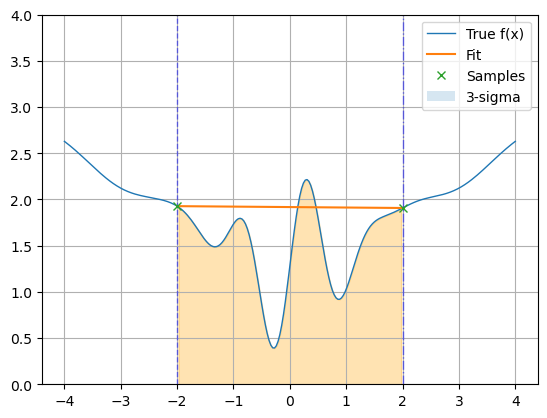

4 pts:
True value: 5.96051236421104

Optimised params: [1.81417745 2.38300373]
Optimised log marginal likelihood: -1.3989114612199167

Estimate: 6.02543585 , StDev: 0.03377719
Absolute Error: 0.06492349



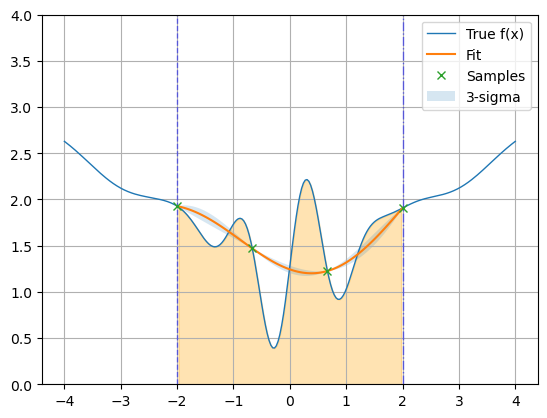

6 pts:
True value: 5.96051236421104

Optimised params: [1.52976285 0.67819713]
Optimised log marginal likelihood: -4.680485576523714

Estimate: 6.03020205 , StDev: 0.13373338
Absolute Error: 0.06968968



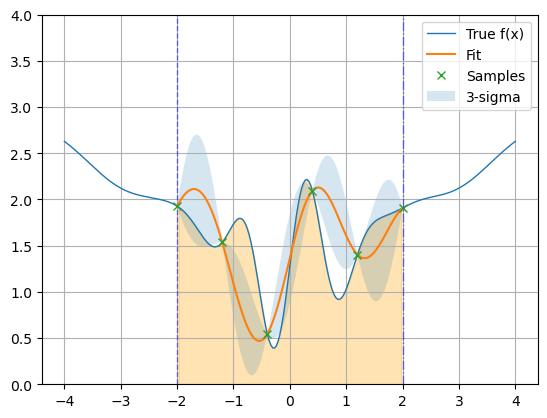

10 pts:
True value: 5.96051236421104

Optimised params: [1.43252596 0.40704599]
Optimised log marginal likelihood: -6.446448848924783

Estimate: 6.00055338 , StDev: 0.05516114
Absolute Error: 0.04004102



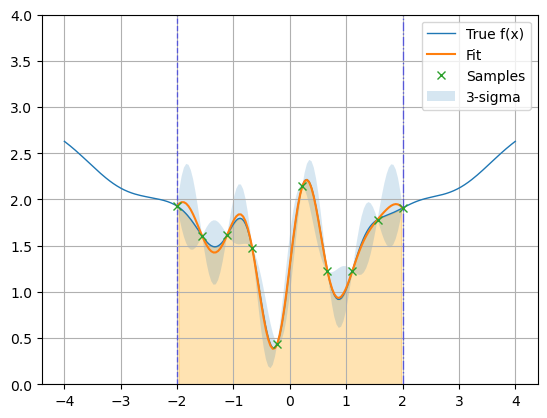

15 pts:
True value: 5.96051236421104

Optimised params: [1.53869974 0.47551346]
Optimised log marginal likelihood: 4.912827163748967

Estimate: 5.96353710 , StDev: 0.00300621
Absolute Error: 0.00302473



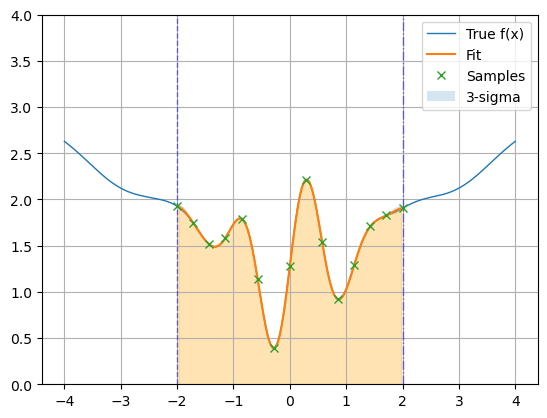

In [4]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
yy = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = yy[mask]


true_value = 5.96051236421104

x_eval = np.linspace(lower,upper,100)
print("Bayesian Quadrature")
for n in [2,4,6,10,15]:
    x = jnp.linspace(lower,upper,n)
    y = f(x)


    grad_fn = grad(neg_gp_likelihood)
    s_init = 1
    #diagonal L
    l_init = jnp.array([1])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood_1(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds=[(1e-3, None)] * len(init_params)
    )


    plt.plot(points,yy, label='True f(x)', linewidth=1)
    plt.axvline(lower, color='b', linestyle='--',linewidth=1, alpha=0.5)
    plt.axvline(upper, color='b', linestyle='-.',linewidth=1, alpha=0.5)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
    plt.grid()

    #kernel hyperparameters
    s = res.x[0]
    L = res.x[1:]


    #points to plot gp
    mu_eval,var_eval = gp_predict_1(x,y,x_eval,kernel=rbf,s=s,L=L)
    sig_diag = jnp.sqrt(jnp.diag(var_eval))

    I_mu, I_var = integrate_rbf(x,y,lower,upper,s,L)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"True value: {true_value}")
    print()
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print()
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    
    #plot gp
    plt.plot(x_eval,mu_eval,label='Fit')
    plt.plot(x,y,'x',label='Samples')
    plt.ylim(0,4)
    plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.18,label='3-sigma')
    plt.legend()
    plt.show()

## Univariate Single Gaussian
### Integrating $f(t)p(t)$

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$



where $$\textbf{k}_F(x) = \Big[ \int k(t, x_1)p(t)dt,\, \int k(t, x_2)p(t)dt,\, \cdots ,\, \int k(t, x_n)p(t)dt \Big]$$,
$$K(x'x) = \int \int k(t, s)p(t)p(s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [5]:
def common_components(
    x, y, s, L, 
    m0=None, x_m=None, w=None, 
    new_k=True):
    x = jnp.atleast_2d(x).astype(jnp.float64)
    if x.shape[0] == 1 and x.shape[1] > 1:
        x = x.T
    y = jnp.atleast_2d(y).reshape(-1, 1)
    n = x.shape[0]

    L = jnp.diag(L)

    if m0 is None:
        m0 = jnp.mean(y)
        x_m = jnp.mean(x, axis=0)
        w = (jnp.max(x, axis=0) - jnp.min(x, axis=0))/5.0
        w = 2

    x_m = jnp.asarray(x_m).reshape(-1)
    w = jnp.asarray(w).reshape(-1)
    m = m0 - 0.5*jnp.sum(((x - x_m)/w) ** 2, axis=1, keepdims=True)
    

    if new_k:

        Kxx = rbf(x, x, s, L) + 1e-10 * jnp.eye(n)
        chol_k = jnp.linalg.cholesky(Kxx)
        return x,y,L,m0,x_m,w,m,chol_k
    else:
        return x,y,L,m0,x_m,w,m
    


def gp_predict(
        xs, ys, x_eval, 
        s,L,m0,x_m,w, m,
        chol_k=None, K_inv=None, old_K=False
        ):
    x_eval = x_eval.reshape(-1, x_m.shape[0])
    M = m0 - 0.5*jnp.sum(((x_eval - x_m)**2)/(w**2), axis=1)



    K_s = rbf(xs, x_eval, s, L)
    K_ss = rbf(x_eval, x_eval, s, L)

    #rank one update is old_k
    if old_K:
        n_old = K_inv.shape[0]
        K12 = rbf(xs[:n_old], xs[n_old:], s, L)
        K21 = K12.T
        K22 = rbf(xs[n_old:], xs[n_old:], s, L)

        # Schur complement
        S = K22 - K21 @ K_inv @ K12
        chol_S = jnp.linalg.cholesky(S + 1e-10 * jnp.eye(S.shape[0]))

        def solve_S(b):
            return jax.scipy.linalg.cho_solve((chol_S, True), b)

        # Updated inverse blocks
        top_left = K_inv + K_inv @ K12 @ solve_S(K21 @ K_inv)
        top_right = -K_inv @ K12 @ solve_S(jnp.eye(K22.shape[0]))
        bottom_left = -solve_S(K21 @ K_inv)
        bottom_right = solve_S(jnp.eye(K22.shape[0]))

        # Assemble updated inverse
        K_inv = jnp.block([
            [top_left, top_right],
            [bottom_left, bottom_right]
        ])
    else:
        #normal update if 
        K_inv = jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(chol_k.shape[0]))

    # Compute mean and covariance
    ym = ys - m

    mu = M + (K_s.T @ K_inv @ ym).ravel()
    sig = K_ss - K_s.T @ K_inv @ K_s + 1e-9 * jnp.eye(K_ss.shape[0])

    return mu.ravel(), sig, K_inv


Eₚ[f(x)]: 1.8682459574322223

Bayesian Quadrature
Optimised params:
Optimal s:  2.366822591066637
Optimal L:  [0.36191422]

2 pts:
Optimised log marginal likelihood: -4.560971735240696
Estimate: -1.32535983 , StDev: 1.59755299
Absolute Error: 3.19360579



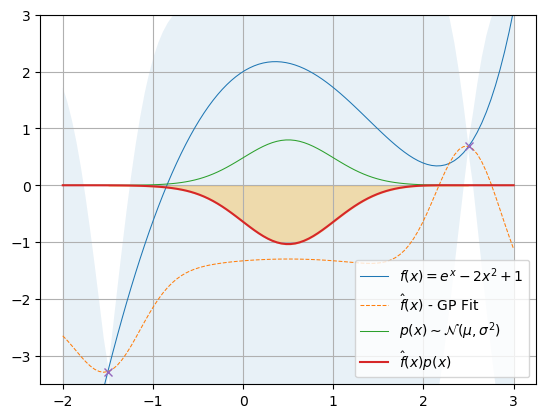

Optimised params:
Optimal s:  2.445204350705494
Optimal L:  [0.54298156]

5 pts:
Optimised log marginal likelihood: -10.044164685536133
Estimate: 1.84240382 , StDev: 0.28378042
Absolute Error: 0.02584214



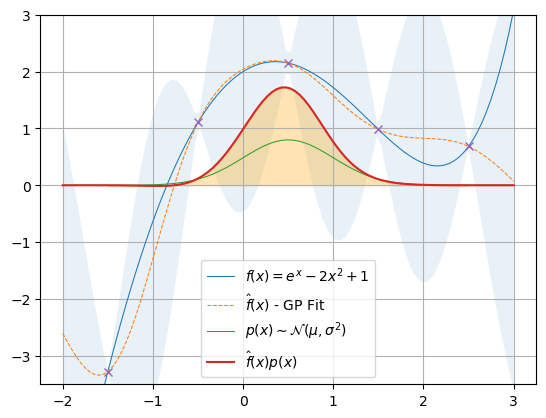

Optimised params:
Optimal s:  5.279041844973083
Optimal L:  [0.65616163]

8 pts:
Optimised log marginal likelihood: -10.435745116320575
Estimate: 1.86842685 , StDev: 0.00534991
Absolute Error: 0.00018089



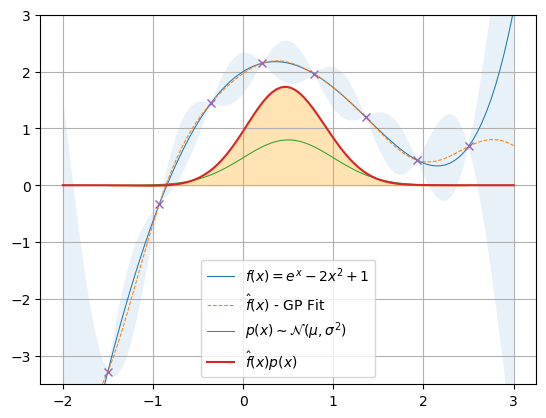

Optimised params:
Optimal s:  26.057971937928848
Optimal L:  [1.0172482]

16 pts:
Optimised log marginal likelihood: 29.365486222177935
Estimate: 1.86824586 , StDev: 0.00000387
Absolute Error: 0.00000009



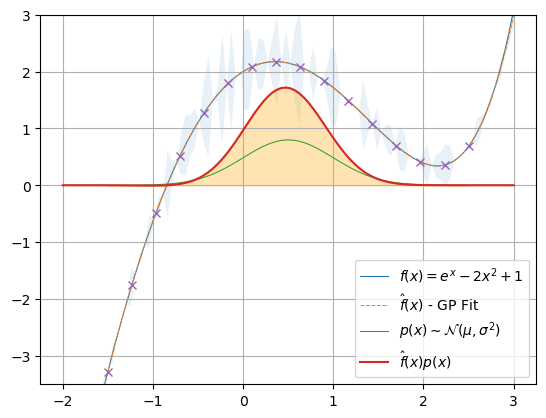

Optimised params:
Optimal s:  37.73145995761891
Optimal L:  [1.10259875]

32 pts:
Optimised log marginal likelihood: 121.44440526246363
Estimate: 1.86824593 , StDev: 0.00000278
Absolute Error: 0.00000003



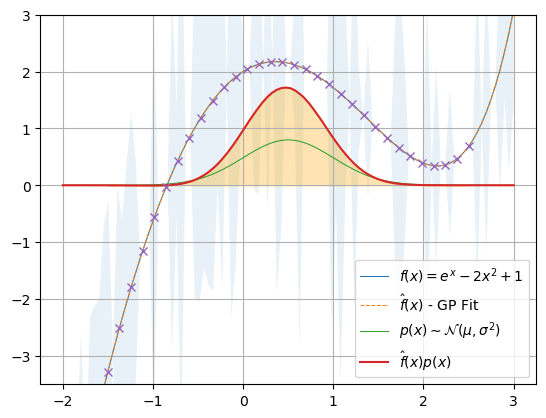

In [ ]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 0.5
sigma = 0.5
true_value = FP(mu,sigma)

x_eval = jnp.linspace(mu-5*sigma,mu+5*sigma,100)

print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [2,5,8,16,32]:
    #maybe do sequential points minimising variance
    x = jnp.linspace(mu-4*sigma,mu+4*sigma,n)
    y = f(x)

    grad_fn = grad(neg_gp_likelihood)

    s_init = 1
    L_init = jnp.array([1])
    init_params = jnp.concatenate([jnp.array([s_init]),L_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds = [(1e-3, None)]*len(init_params)

    )

    #kernel hyperparameters
    s = res.x[0]
    L = res.x[1:]/2

    print("Optimised params:")
    print("Optimal s: ",s)
    print("Optimal L: ",L)
    print()

    I_mu, I_var = integrate_gaussian_1(x,y,s,L,mu,sigma)

    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print("Optimised log marginal likelihood:", -res.fun)
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    x1,y1,L1,m01,x_m1,w1,m1,chol_k1 = common_components(
        x, y, s=s, L=L, 
        m0=None, x_m=None, w=None, 
        new_k=True
        )
    
    mu_eval, var_eval, K_inv = gp_predict(
        x1, y1, x_eval,
        s=s,L=L1,
        m0=m01,x_m=x_m1,w=w1,m=m1,
        chol_k=chol_k1, K_inv=None, old_K=False)
    sig_diag = np.sqrt(jnp.clip(np.diag(var_eval), 0.0))

    #real curve
    y1 = f(x_eval)
    y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
    y3 = y2*mu_eval


    mask = (x_eval >= mu-4*sigma) & (x_eval <= mu+4*sigma)
    points_fill = x_eval[mask]
    y_fill = y3[mask]

    #plot gp
    plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
    plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
    plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
    plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
    plt.plot(x,y,'x')
    plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
    plt.legend()
    plt.ylim(-3.5,3)
    plt.grid()
    plt.show()

## Univariate Mixture
### Integrating $f(t)p_{mix}(t)$

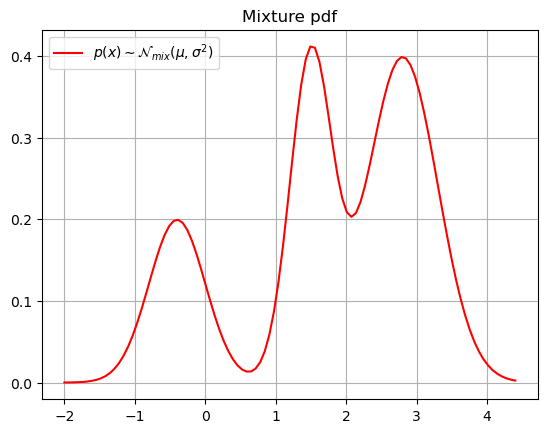

Eₚ[f(x)]: -0.15931328397645778

Bayesian Quadrature
Optimised params:
Optimal s:  0.36898049879062456
Optimal L:  [0.5973632]

3 pts:
Optimised log marginal likelihood: -1.2658254555696873
Estimate: 0.20060541 , StDev: 0.48619993
Absolute Error: 0.35991869



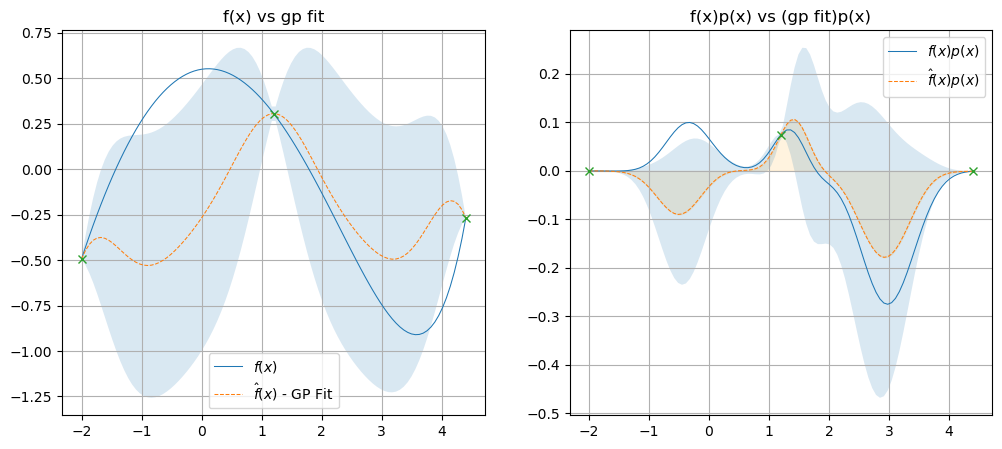

Optimised params:
Optimal s:  0.4217604945088499
Optimal L:  [0.33501323]

4 pts:
Optimised log marginal likelihood: -2.22249109782519
Estimate: 0.26403119 , StDev: 0.47442923
Absolute Error: 0.42334448



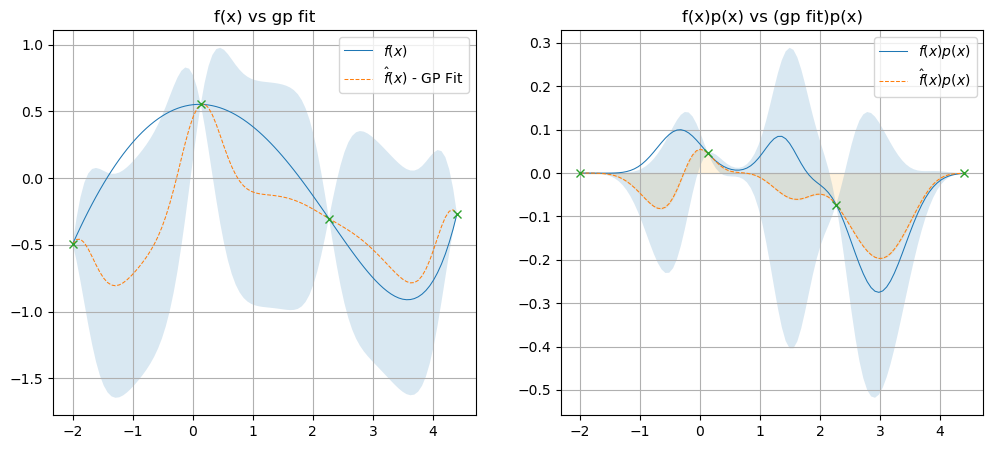

Optimised params:
Optimal s:  0.46016205158475904
Optimal L:  [0.26506549]

5 pts:
Optimised log marginal likelihood: -3.2138374341063103
Estimate: 0.14248933 , StDev: 0.36389905
Absolute Error: 0.30180262



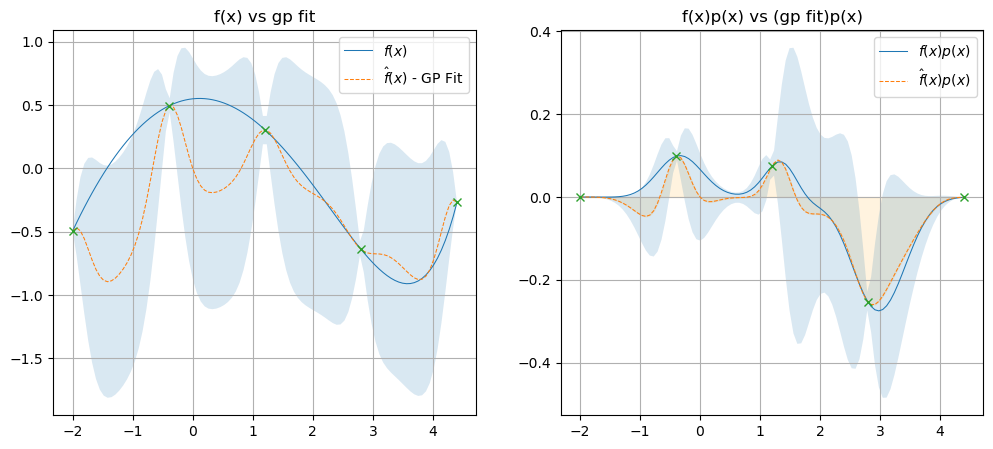

Optimised params:
Optimal s:  0.49736014351195507
Optimal L:  [0.99163491]

6 pts:
Optimised log marginal likelihood: -3.7150906834093793
Estimate: -0.16073675 , StDev: 0.02472072
Absolute Error: 0.00142346



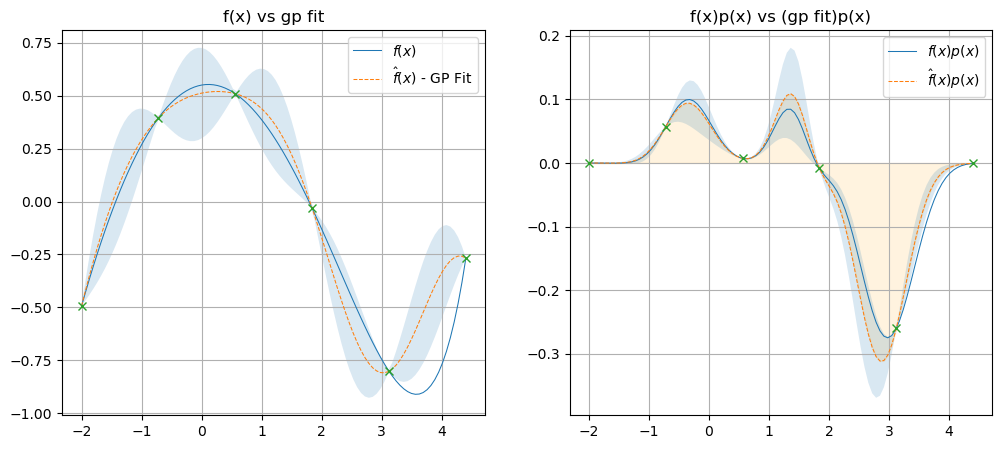

Optimised params:
Optimal s:  0.5568937541498432
Optimal L:  [1.15621622]

7 pts:
Optimised log marginal likelihood: -3.4314746573882906
Estimate: -0.15912161 , StDev: 0.02240160
Absolute Error: 0.00019168



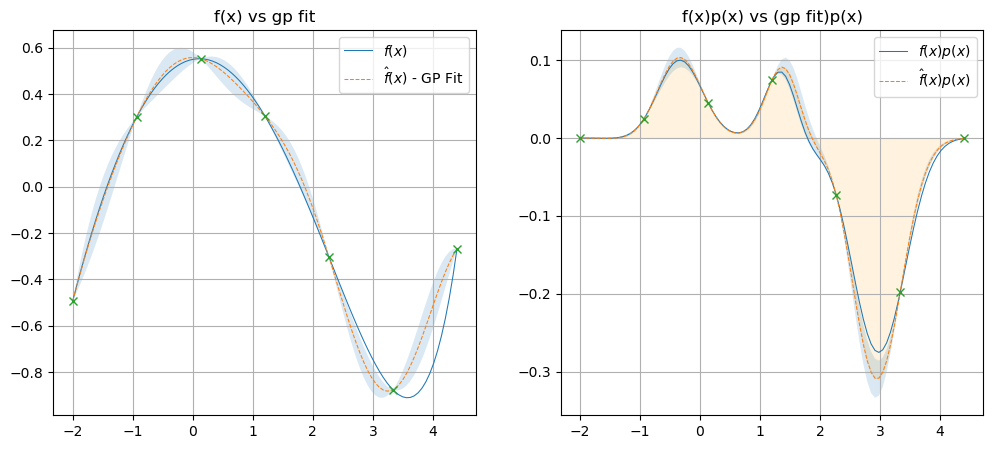

Optimised params:
Optimal s:  0.5430153763611779
Optimal L:  [1.04806799]

8 pts:
Optimised log marginal likelihood: -3.1111496870080737
Estimate: -0.16335992 , StDev: 0.01498588
Absolute Error: 0.00404663



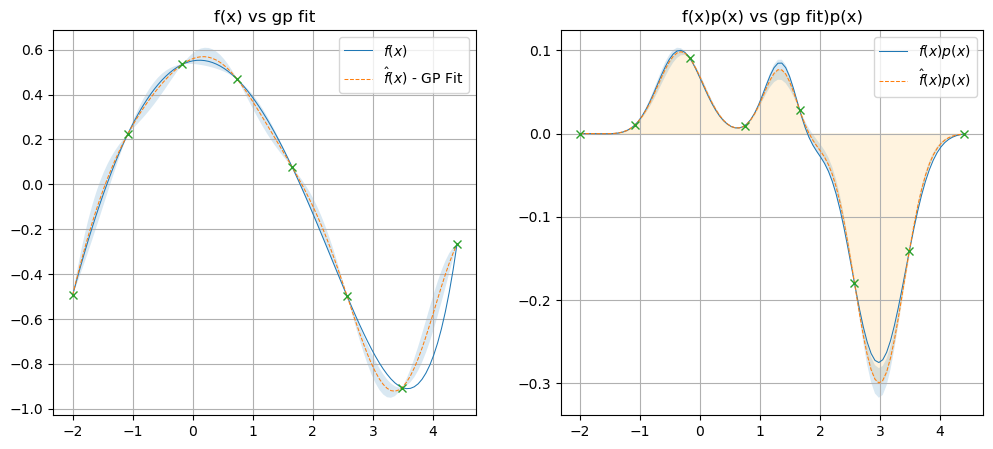

Optimised params:
Optimal s:  4.331667016524468
Optimal L:  [1.89386056]

12 pts:
Optimised log marginal likelihood: 5.507375730617584
Estimate: -0.15931440 , StDev: 0.00001159
Absolute Error: 0.00000112



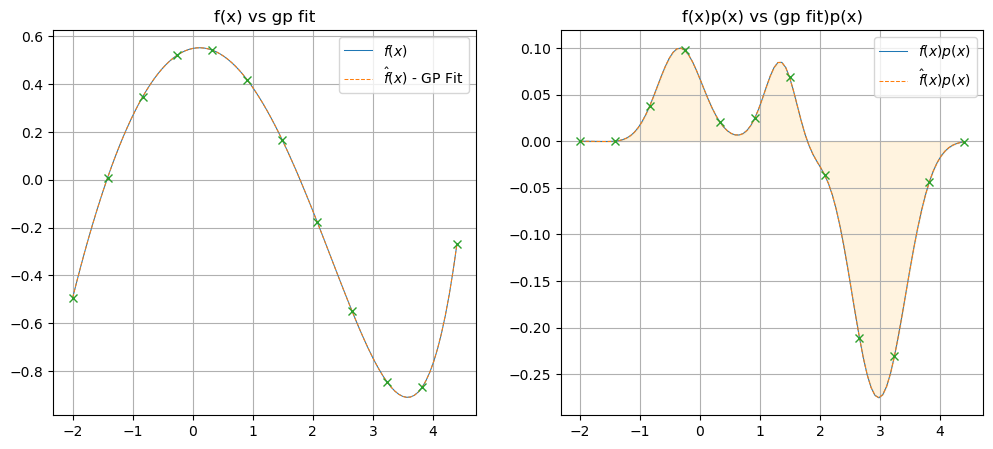

In [ ]:
def f(x):
    return 0.5*(0.1*jnp.exp(x) - 0.5*x**2 + 1)

def fp_mix(x, params, weights=None):
    mu_params = jnp.array(params[0])
    s_params = jnp.array(params[1])
    n_components = len(mu_params)

    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    # compute sum of f(x) * p(x) over mixture components
    px_sum = 0.0
    for i in range(n_components):
        px = (1/(s_params[i]*jnp.sqrt(2*jnp.pi))) * \
             jnp.exp(-(x - mu_params[i])**2/(2*s_params[i]**2))
        px_sum += weights[i]*f(x)*px

    return px_sum

def FP(params, weights=None):
    mu_params = jnp.array(params[0])
    s_params = jnp.array(params[1])
    n_components = len(mu_params)

    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    integral = 0.0
    for i in range(n_components):
        t1 = 0.1*jnp.exp(s_params[i]**2/2 + mu_params[i])
        integral += weights[i]*0.5*(t1 - 0.5*s_params[i]**2 - 0.5*mu_params[i]**2 + 1)

    return integral


mu = jnp.array([-0.4, 1.5, 2.8])
sigma = jnp.array([0.4, 0.3, 0.5])
weights = jnp.array([0.2, 0.3, 0.5])
params = (mu, sigma)
true_value = FP(params, weights)


lower = min(mu)-4*jnp.mean(sigma)
upper = max(mu)+4*jnp.mean(sigma)

#points to plot gp
x_eval = np.linspace(lower,upper,100)

#mixture
y1 = mixture_pdf_1(x_eval, params[0], params[1], weights=weights)

#curve
y2 = f(x_eval)

#integral function
y4 = fp_mix(x_eval, params, weights)

plt.plot(x_eval, y1, label=r'$p(x) \sim \mathcal{N}_{mix}(\mu, \sigma^2)$', color='red')
plt.legend()
plt.grid()
plt.title("Mixture pdf")
plt.show()

mask = (x_eval >= lower) & (x_eval <= upper)
points_fill = x_eval[mask]


print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [3,4,5,6,7,8,12]:

    x = np.linspace(lower,upper,n)
    y = f(x)

    grad_fn = grad(neg_gp_likelihood)

    s_init = 1
    L_init = jnp.array([1])
    init_params = jnp.concatenate([jnp.array([s_init]), L_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
        method="L-BFGS-B",
        bounds = [(1e-1, 20)]*len(init_params)
    )

    #kernel hyperparameters
    s = res.x[0]
    L = res.x[1:]

    print("Optimised params:")
    print("Optimal s: ",s)
    print("Optimal L: ",L)
    print()

    I_mu, I_var = integrate_mixture_1(x,y,s,L,params, weights)

    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print("Optimised log marginal likelihood:", -res.fun)
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    x1,yy,L1,m01,x_m1,w1,m1,chol_k1 = common_components(
        x, y, s=s, L=L, 
        m0=None, x_m=None, w=None, 
        new_k=True
        )
    
    mu_eval, var_eval, K_inv = gp_predict(
        x1, yy, x_eval,
        s=s,L=L1,
        m0=m01,x_m=x_m1,w=w1,m=m1,
        chol_k=chol_k1, K_inv=None, old_K=False)
    sig_diag = np.sqrt(jnp.clip(np.diag(var_eval), 0.0, None))

    y3 = mu_eval
    y5 = y1*y3

    y_fill = y5[mask]

    #plot
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(x_eval,y2,label=r'$f(x)$', ls='-',lw=0.75)
    plt.plot(x_eval,y3, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
    plt.plot(x,y,'x')
    plt.fill_between(x_eval,
                    mu_eval - 2*sig_diag,
                    mu_eval + 2*sig_diag,
                    alpha=0.17)
    plt.legend()
    plt.grid()
    plt.title("f(x) vs gp fit")


    plt.subplot(1,2,2)
    plt.plot(x_eval,y4,label=r'${f}(x)p(x)$', ls='-', lw=0.75)
    plt.plot(x_eval,y5,label=r'$\hat{f}(x)p(x)$', ls='--', lw=0.75)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.125) 
    plt.fill_between(x_eval,
                    y1*mu_eval - 2*np.abs(y1)*sig_diag,
                    y1*mu_eval + 2*np.abs(y1)*sig_diag,
                    alpha=0.17)
    plt.plot(x,y*mixture_pdf_1(x,params[0], params[1], weights),'x')
    plt.legend()
    plt.grid()
    plt.title("f(x)p(x) vs (gp fit)p(x)")
    plt.show()